In [3]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle as pkl

%matplotlib inline
sns.set_theme()

In [37]:
df = pd.read_csv("data/reddit-finance-posts.csv")

# convert created, retrieved, edited to datetime
df["created"] = pd.to_datetime(df["created"])
df["retrieved"] = pd.to_datetime(df["retrieved"])
df["edited"] = pd.to_datetime(df["edited"])

In [3]:
df.columns

Index(['id', 'author', 'created', 'retrieved', 'edited', 'pinned', 'archived',
       'locked', 'removed', 'deleted', 'is_self', 'is_video',
       'is_original_content', 'title', 'link_flair_text', 'upvote_ratio',
       'score', 'gilded', 'total_awards_received', 'num_comments',
       'num_crossposts', 'selftext', 'thumbnail', 'shortlink', 'subreddit'],
      dtype='object')

In [4]:
len(df)

492926

/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/x1/qrh5ny5938qfp9td0bfdhv9r0000gn/T/ipykernel_4715/2621791086.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ti

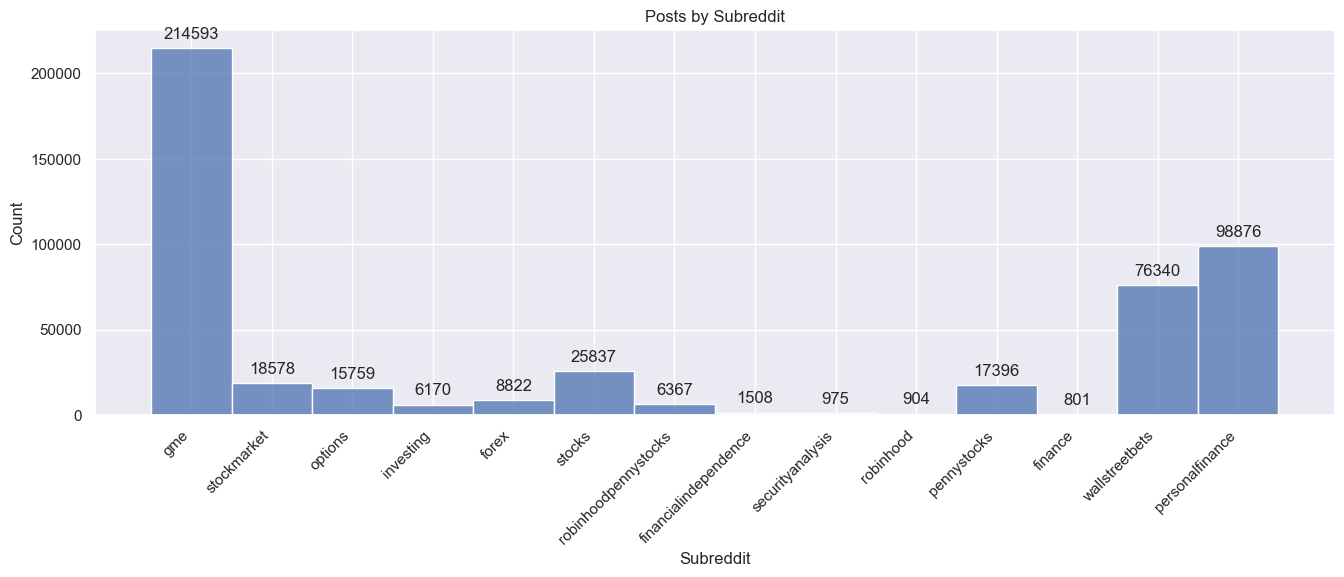

In [5]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.histplot(df["subreddit"], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Subreddit")
ax.set_ylabel("Count")
ax.set_title("Posts by Subreddit")

# show the count on the bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

In [6]:
subset = df[["created", "selftext"]].copy()
subset["selftext"].fillna("", inplace=True)

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    try:
        return sid.polarity_scores(text)["compound"]
    except:
        return 0

get_sentiment_score("I am really unhappy")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pranav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


-0.4754

In [8]:
# remove links from selftext
import re
def remove_links(text):
    return re.sub(r"http\S+", "", text)

subset["selftext"] = subset["selftext"].apply(remove_links)

In [9]:
subset.selftext[0]

'After watching this I took a position RIGHT AWAY 🚀 '

In [10]:
subset["sentiment_score"] = subset["selftext"].apply(get_sentiment_score)

In [2]:
import pickle as pkl

LOAD = True

if not LOAD:
    with open("data/sentiment_scores.pkl", "wb") as f:
        pkl.dump(subset, f)
    
else:
    with open("data/sentiment_scores.pkl", "rb") as f:
        subset = pkl.load(f)

In [3]:
sp500_firms = pd.read_csv("data/sp500-firms.csv")
sp500_firms.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
tickers = sp500_firms["Symbol"].tolist()
firm_names = sp500_firms["Security"].tolist()

In [5]:
subset

,created,selftext,sentiment_score
0,2021-01-04 19:02:26,After watching this I took a position RIGHT AW...,0.0000
1,2021-01-05 10:19:59,This guy explained exactly how to take a posit...,0.5371
2,2021-01-06 13:25:49,Any speculation or ideas on what Gamestop migh...,0.9506
3,2021-01-10 21:59:17,"After some downwards movement, I think everyb...",0.8685
4,2021-01-11 12:36:32,,0.0000
...,...,...,...
492921,2021-12-31 23:00:46,About to start a ROTH IRA with vanguard. Shoul...,0.0000
492922,2021-12-31 23:07:52,Or is there still time? Thinking about maxing ...,0.0000
492923,2021-12-31 23:31:41,\n\nhi i am a young man and I was working fo...,0.9630
492924,2021-12-31 23:50:17,What are the best keeper cards? I know the ven...,0.8426


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

tickers_mlb = MultiLabelBinarizer()
tickers_mlb.fit([tickers])
firm_names_mlb = MultiLabelBinarizer()
firm_names_mlb.fit([firm_names])

# def get_tickers(text):
#     return tickers_mlb.transform([[text.split()]])

# get_tickers("I like $AAPL and $TSLA")

results = tickers_mlb.transform(["I like $AAPL and $NVDA".replace("$", "").split()])

/Users/pranav/Projects/cos497/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['I', 'and', 'like'] will be ignored
  warnings.warn(


In [7]:
mask_df = pd.DataFrame([], columns=[f"is_{x}" for x in tickers_mlb.classes_])

In [8]:
import warnings
warnings.filterwarnings("ignore")

subset_mask = subset.apply(lambda x: tickers_mlb.transform([x["selftext"].replace("$", "").split()]), axis=1)

In [9]:
subset_mask = subset_mask.apply(lambda x: x.reshape(-1))

In [10]:
mask_df = pd.DataFrame(subset_mask.tolist(), columns=tickers_mlb.classes_)

In [11]:
mask_df.columns = [f"is_{x}" for x in mask_df.columns]

In [12]:
subset = pd.concat((subset, mask_df), axis=1)

In [14]:
with open("data/post-firm-sentiment.pkl", "wb") as f:
    pkl.dump(subset, f)

In [4]:
with open("data/post-firm-sentiment.pkl", "rb") as f:
    subset = pkl.load(f)

In [5]:
subset

,created,selftext,sentiment_score,is_A,is_AAL,is_AAPL,is_ABBV,is_ABNB,is_ABT,is_ACGL,...,is_WYNN,is_XEL,is_XOM,is_XRAY,is_XYL,is_YUM,is_ZBH,is_ZBRA,is_ZION,is_ZTS
0,2021-01-04 19:02:26,After watching this I took a position RIGHT AW...,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-05 10:19:59,This guy explained exactly how to take a posit...,0.5371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-06 13:25:49,Any speculation or ideas on what Gamestop migh...,0.9506,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-10 21:59:17,"After some downwards movement, I think everyb...",0.8685,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-11 12:36:32,,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492921,2021-12-31 23:00:46,About to start a ROTH IRA with vanguard. Shoul...,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492922,2021-12-31 23:07:52,Or is there still time? Thinking about maxing ...,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492923,2021-12-31 23:31:41,\n\nhi i am a young man and I was working fo...,0.9630,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492924,2021-12-31 23:50:17,What are the best keeper cards? I know the ven...,0.8426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
